# Import initial libraries 

In [18]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections [FACEMESH_TESSELATION]
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)) 

# Test MediaPipe Function with real camera 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [10]:
# Directory path containing the videos
videos_path = '/GitHub/TSL_Recognition/TSL10/Videos/IAm/'

# Get all files in the directory
file_list = os.listdir(videos_path)

# Filter video files
video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

# Iterate over video files
for video_file in video_files:
    # Construct the full path to the video file
    video_path = os.path.join(videos_path, video_file)

    # Initialize VideoCapture object
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # Convert the frame to RGB format
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Detect actions
            results = holistic.process(frame_rgb)

            # Draw landmarks and actions on the frame
            draw_styled_landmarks(image, results)

            # Display the resulting frame
            cv2.imshow('Video', image)

            # Press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Release the video capture
    cap.release()

# Close windows
cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [6]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/GitHub/TSL_Recognition/TSL10/Extracted_Keypoints') 

# Actions that we try to detect
# actions = np.array(['hello'])

actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])

# Thirty videos worth of data
no_sequences = 85

# Videos are going to be 30 frames in length
sequence_length = 30

In [ ]:
#for sequence in range(30, no_sequences + 30)
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
# Set the path to the directory containing the videos
videos_dir = '/GitHub/TSL_Recognition/TSL10/Videos/'

# Set mediapipe model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through each folder
    for folder_name in os.listdir(videos_dir):
        folder_path = os.path.join(videos_dir, folder_name)

        # Check if it is a directory
        if not os.path.isdir(folder_path):
            continue

        # Get a list of all video files in the folder
        video_files = [f for f in os.listdir(folder_path)]

        # Loop through each video file
        for video_file in video_files:
            # Construct the full path to the video file
            video_path = os.path.join(folder_path, video_file)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Remove the file extension from the video file name
            video_file_name = os.path.splitext(video_file)[0]

            # Create a folder to save keypoints for each video
            keypoints_dir = os.path.join(DATA_PATH, folder_name, video_file_name)
            os.makedirs(keypoints_dir, exist_ok=True)

            # Loop through frames in the video
            frame_num = 0
            while cap.isOpened():
                # Read feed
                ret, frame = cap.read()

                if not ret:
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(keypoints_dir, str(frame_num))
                np.save(npy_path, keypoints)

                frame_num += 1

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()

# Prepare Data for train and test

In [7]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
X_train.shape

(680, 30, 1662)

# Train model

Train LSTM Model

In [20]:
# K-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracy_scores = []

for train_index, test_index in skf.split(X, labels):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_LSTM = Sequential([
        LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
        Dropout(0.1),
        LSTM(128, return_sequences=True, activation='relu'),
        Dropout(0.1),
        LSTM(64, return_sequences=False, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(actions.shape[0], activation='softmax')
    ])

    model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32)

    _, accuracy = model_LSTM.evaluate(X_test, y_test)
    accuracy_scores.append(accuracy)

print("Accuracy scores for each fold:", accuracy_scores)
print("Mean accuracy:", np.mean(accuracy_scores))

Epoch 1/300
22/22 [==============================] - 6s 112ms/step - loss: 2.7468 - categorical_accuracy: 0.0956 - val_loss: 2.3206 - val_categorical_accuracy: 0.1000
Epoch 2/300
22/22 [==============================] - 2s 90ms/step - loss: 2.3169 - categorical_accuracy: 0.0985 - val_loss: 2.3037 - val_categorical_accuracy: 0.1000
Epoch 3/300
22/22 [==============================] - 2s 89ms/step - loss: 2.3049 - categorical_accuracy: 0.1059 - val_loss: 2.2949 - val_categorical_accuracy: 0.1000
Epoch 4/300
22/22 [==============================] - 2s 83ms/step - loss: 2.3037 - categorical_accuracy: 0.1044 - val_loss: 2.2929 - val_categorical_accuracy: 0.1235
Epoch 5/300
22/22 [==============================] - 2s 85ms/step - loss: 2.3001 - categorical_accuracy: 0.1309 - val_loss: 2.2946 - val_categorical_accuracy: 0.1235
Epoch 6/300
22/22 [==============================] - 2s 82ms/step - loss: 2.2980 - categorical_accuracy: 0.1176 - val_loss: 2.3015 - val_categorical_accuracy: 0.1000
Epo

KeyboardInterrupt: 

In [14]:
model_LSTM = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
    Dropout(0.1),
    LSTM(128, return_sequences=True, activation='relu'),
    Dropout(0.1),
    LSTM(64, return_sequences=False, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax')])

model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=[
                   'categorical_accuracy'])
model_LSTM.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=300, batch_size=32)

Epoch 1/300
16/16 [==============================] - 10s 215ms/step - loss: 2.6429 - categorical_accuracy: 0.1000 - val_loss: 2.3022 - val_categorical_accuracy: 0.1029
Epoch 2/300
16/16 [==============================] - 2s 122ms/step - loss: 2.2975 - categorical_accuracy: 0.1059 - val_loss: 2.2959 - val_categorical_accuracy: 0.1029
Epoch 3/300
16/16 [==============================] - 2s 119ms/step - loss: 2.2947 - categorical_accuracy: 0.1078 - val_loss: 2.2825 - val_categorical_accuracy: 0.1029
Epoch 4/300
16/16 [==============================] - 2s 118ms/step - loss: 2.2960 - categorical_accuracy: 0.1294 - val_loss: 2.2711 - val_categorical_accuracy: 0.1500
Epoch 5/300
16/16 [==============================] - 2s 119ms/step - loss: 2.2906 - categorical_accuracy: 0.1431 - val_loss: 2.2931 - val_categorical_accuracy: 0.1824
Epoch 6/300
16/16 [==============================] - 2s 119ms/step - loss: 2.2932 - categorical_accuracy: 0.1588 - val_loss: 2.2858 - val_categorical_accuracy: 0.10

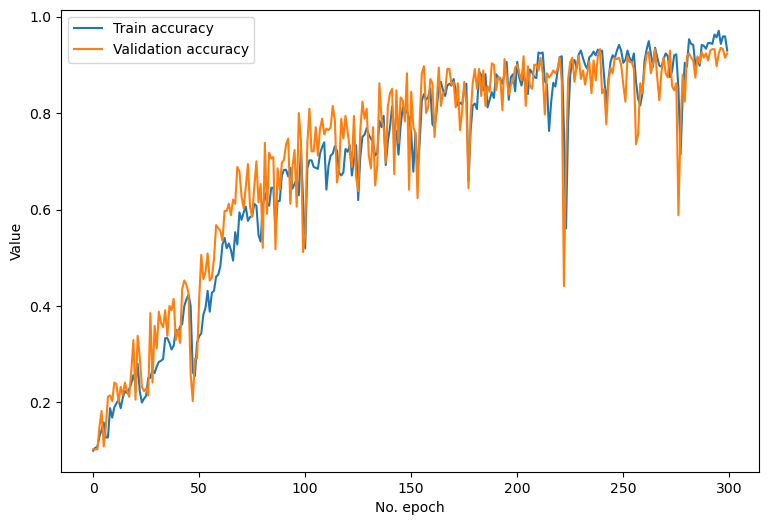

In [15]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_LSTM.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

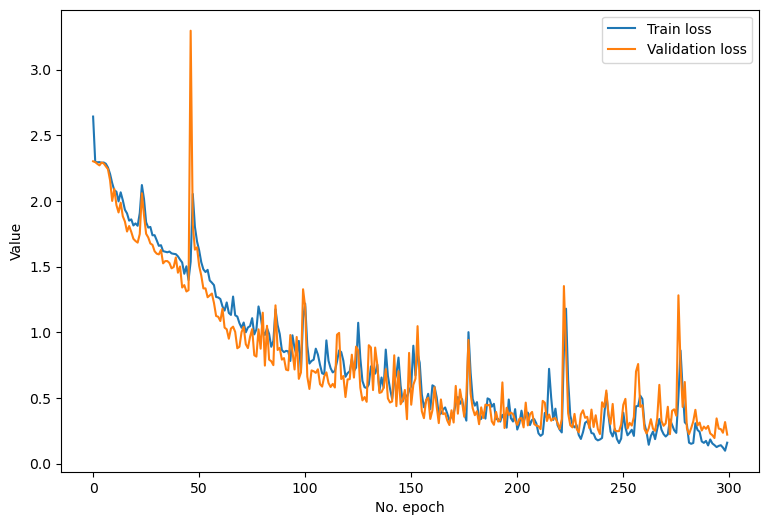

In [16]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['loss'], label='Train loss')
plt.plot(model_LSTM.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [17]:
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 64)            442112    
                                                                 
 dropout_12 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_13 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [18]:
model_LSTM.save('../LSTM/LSTM_Model.h5')

In [19]:
model_LSTM = load_model('../LSTM/LSTM_Model.h5')

Test Accuracy Model

In [20]:
yhat = model_LSTM.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_LSTM.evaluate(X_train, y_train)
model_LSTM.evaluate(X_test, y_test)
# accuracy_score(ytrue, yhat)

11/11 [==============================] - 0s 29ms/step - loss: 0.2205 - categorical_accuracy: 0.9235


[0.2204952985048294, 0.9235293865203857]

In [21]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[308,   1],
        [  1,  30]],

       [[306,   0],
        [  1,  33]],

       [[304,   2],
        [  1,  33]],

       [[302,   7],
        [  6,  25]],

       [[310,   1],
        [  4,  25]],

       [[296,   4],
        [  5,  35]],

       [[303,   2],
        [  0,  35]],

       [[305,   0],
        [  3,  32]],

       [[302,   4],
        [  1,  33]],

       [[298,   5],
        [  4,  33]]], dtype=int64)

# Test Model in real time

In [24]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.8

cap = cv2.VideoCapture(0)
resolution = (800, 600)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step


Test With Video

In [32]:
sequence = []
sentence = []
predictions = []
confidence = 0.95

# Directory path containing the videos
videos_path = '/GitHub/TSL_Recognition/Collect_videos/Hello/'

# Get all files in the directory
file_list = os.listdir(videos_path)

# Filter video files
video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

# Iterate over video files
for video_file in video_files:
    # Construct the full path to the video file
    video_path = os.path.join(videos_path, video_file)

    # Initialize VideoCapture object
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # Convert the frame to RGB format
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Detect actions
            results = holistic.process(frame_rgb)

            # Draw landmarks and actions on the frame
            draw_styled_landmarks(image, results)
            
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                # 3. Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] >= confidence:

                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

            cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
            cv2.putText(image, ' '.join(sentence), (3, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display the resulting frame
            cv2.imshow('Video', image)

            # Press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Release the video capture
    cap.release()

# Close windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
